In [ ]:
# https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
# cnn 계열의 모델(vgg, resnet, .. 을 써서 학습시켜 최종결과 확인 -> 검증기반데이터셋(val)로 검증 : 정확도, f1 score 뽑기
# val = 8개 -> 배치사이즈 8개로 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, datasets, transforms
import numpy as np

In [8]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_datasets = datasets.ImageFolder(root="data/chest_xray/train", transform=transforms_train)
test_datasets = datasets.ImageFolder(root="data/chest_xray/test", transform=transforms_test)

In [9]:
train_datasets

Dataset ImageFolder
    Number of datapoints: 5216
    Root location: data/chest_xray/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [10]:
train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=8, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=8, shuffle=True)

In [11]:
images, labels = next(iter(train_dataloader))

In [12]:
images.shape  

torch.Size([8, 3, 224, 224])

In [13]:
labels.shape

torch.Size([8])

In [14]:
import matplotlib.pyplot as plt

# 이미지를 화면에 출력하는 함수
def imshow(img, title) :
    img = img.numpy().transpose([1, 2, 0])

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    img = img * std + mean      # 원래 이미지로 복구
    img = np.clip(img, 0, 1)    # 해도되고, 안해도되고

    plt.imshow(img)
    plt.title(title)
    plt.show()

In [15]:
images_data = torchvision.utils.make_grid(images)

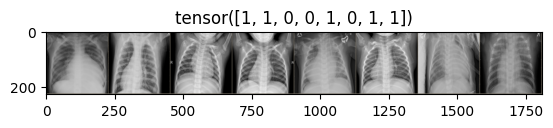

In [16]:
imshow(images_data, labels)

In [17]:
train_datasets.classes

['NORMAL', 'PNEUMONIA']

In [18]:
# resnet 모델
model = models.resnet34(pretrained=True)
model

c:\deep_learning\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\deep_learning\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [20]:
for param in model.parameters() :
    param.requires_grad = False

model.fc = nn.Linear(in_features=512, out_features=8, bias=True)

In [21]:
model.fc

Linear(in_features=512, out_features=8, bias=True)

In [22]:
from tensorboardX import SummaryWriter
import tqdm

writer = SummaryWriter()

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
epochs = 10

step = 0

device = torch.device("cpu")
model.to(device)

for epoch in range(epochs) :
    for data, labels in tqdm.tqdm(train_dataloader) :
        optimizer.zero_grad()
        pred = model(data.to(device))
        loss = criterion(pred, labels.to(device))
        writer.add_scalar("Loss/train", loss.item(), step)
        loss.backward()
        optimizer.step()
        step += 1

    print(f"loss ::: {loss.item()}")

  0%|          | 0/652 [00:00<?, ?it/s]

  6%|▌         | 39/652 [01:45<27:40,  2.71s/it]


KeyboardInterrupt: 

In [4]:
torch.cuda.is_available()

False